# CDP - 236370
## Tutorial 3

Written by Ido Hakimi
<br>
Adapted from https://gist.github.com/wiseodd/85ad008aef5585cec017f4f1e6d67a02

Videos:
* https://www.youtube.com/watch?v=PCBTZh41Ris
* https://www.youtube.com/watch?v=gn4nRCC9TwQ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
n_feature = 2
n_class = 2

X, y = make_moons(n_samples=5000, random_state=42, noise=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

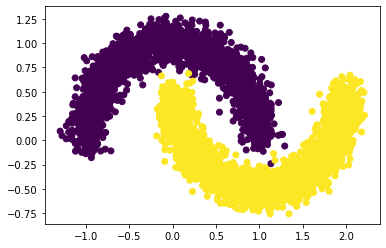

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
def make_network(n_hidden=100):
    model = dict(
        W1=np.random.randn(n_feature, n_hidden),
        W2=np.random.randn(n_hidden, n_class)
    )
    return model

In [5]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def forward(x, model):
    # Input to hidden
    h = x @ model['W1']
    h[h < 0] = 0             # relu(h) == max(h, 0)
    y = h @ model['W2']
    # Hidden to output
    prob = softmax(y)

    return h, prob

In [6]:
def backward(model, xs, hs, errs):
    dW2 = hs.T @ errs
    dh = errs @ model['W2'].T
    dh[hs < 0] = 0
    dW1 = xs.T @ dh

    return dict(W1=dW1, W2=dW2)

In [7]:
def shuffle(X, y):
    Z = np.column_stack((X, y))
    np.random.shuffle(Z)
    return Z[:, :-1], Z[:, -1]


def get_minibatch(X, y, minibatch_size):
    minibatches = []

    X, y = shuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

In [8]:
def get_minibatch_grad(model, X_train, y_train):
    xs, hs, errs = [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward(x, model)

        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.
        err = y_true - y_pred

        xs.append(x)
        hs.append(h)
        errs.append(err)

    return backward(model, np.array(xs), np.array(hs), np.array(errs))

In [9]:
def sgd(model, X_train, y_train, minibatch_size):
    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for i in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for layer in grad:
            model[layer] += alpha * grad[layer]

    return model

In [10]:
def momentum(model, X_train, y_train, minibatch_size):
    velocity = {k: np.zeros_like(v) for k, v in model.items()}
    gamma = .9

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for i in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for layer in grad:
            velocity[layer] = gamma * velocity[layer] + alpha * grad[layer]
            model[layer] += velocity[layer]

    return model

def nesterov(model, X_train, y_train, minibatch_size):
    velocity = {k: np.zeros_like(v) for k, v in model.items()}
    gamma = .9

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for e in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        model_ahead = {k: v + gamma * velocity[k] for k, v in model.items()}
        grad = get_minibatch_grad(model_ahead, X_mini, y_mini)

        for layer in grad:
            velocity[layer] = gamma * velocity[layer] + alpha * grad[layer]
            model[layer] += velocity[layer]

    return model

def adagrad(model, X_train, y_train, minibatch_size):
    cache = {k: np.zeros_like(v) for k, v in model.items()}

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for e in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for k in grad:
            cache[k] += grad[k]**2
            model[k] += alpha * grad[k] / (np.sqrt(cache[k]) + eps)

    return model


def rmsprop(model, X_train, y_train, minibatch_size):
    cache = {k: np.zeros_like(v) for k, v in model.items()}
    gamma = .9

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for e in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for k in grad:
            cache[k] = gamma * cache[k] + (1 - gamma) * (grad[k]**2)
            model[k] += alpha * grad[k] / (np.sqrt(cache[k]) + eps)

    return model


def adam(model, X_train, y_train, minibatch_size):
    M = {k: np.zeros_like(v) for k, v in model.items()}
    R = {k: np.zeros_like(v) for k, v in model.items()}
    beta1 = .9
    beta2 = .999

    minibatches = get_minibatch(X_train, y_train, minibatch_size)

    for e in range(1, n_iter + 1):
        idx = np.random.randint(0, len(minibatches))
        X_mini, y_mini = minibatches[idx]

        grad = get_minibatch_grad(model, X_mini, y_mini)

        for k in grad:
            M[k] = beta1 * M[k] + (1. - beta1) * grad[k]
            R[k] = beta2 * R[k] + (1. - beta2) * grad[k]**2

            m_k_hat = M[k] / (1. - beta1**(e))
            r_k_hat = R[k] / (1. - beta2**(e))

            model[k] += alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

    return model

In [11]:
n_iter = 100
eps = 1e-8  # Smoothing to avoid division by zero
alpha = 1e-3
minibatch_size = 100
n_experiment = 10

algos = dict(
    sgd=sgd,
    momentum=momentum,
    nesterov=nesterov,
    adagrad=adagrad,
    rmsprop=rmsprop,
    adam=adam
)

algo_accs = {k: np.zeros(n_experiment) for k in algos}

for algo_name, algo in algos.items():
    print('Experimenting on {}'.format(algo_name))

    for k in range(n_experiment):
        # print('Experiment-{}'.format(k))

        # Reset model
        model = make_network()
        model = algo(model, X_train, y_train, minibatch_size)

        y_pred = np.zeros_like(y_test)

        for i, x in enumerate(X_test):
            _, prob = forward(x, model)
            y = np.argmax(prob)
            y_pred[i] = y

        algo_accs[algo_name][k] = np.mean(y_pred == y_test)

print()

for k, v in algo_accs.items():
    print('{} => mean accuracy: {}, std: {}'.format(k, v.mean(), v.std()))

Experimenting on sgd
Experimenting on momentum
Experimenting on nesterov
Experimenting on adagrad
Experimenting on rmsprop
Experimenting on adam

sgd => mean accuracy: 0.87632, std: 0.005681689889460714
momentum => mean accuracy: 0.8699200000000001, std: 0.01267034332605082
nesterov => mean accuracy: 0.8784000000000001, std: 0.0012899612397277637
adagrad => mean accuracy: 0.5310400000000001, std: 0.2110738411077981
rmsprop => mean accuracy: 0.8204800000000001, std: 0.047163647017591834
adam => mean accuracy: 0.7710400000000001, std: 0.14207279260998568


In [19]:
def plot_algo(algo):
    print('Plotting {}'.format(algo.__name__))
    model = make_network()
    model = algo(model, X_train, y_train, minibatch_size)

    y_pred = np.zeros_like(y_test)

    for i, x in enumerate(X_test):
        _, prob = forward(x, model)
        y = np.argmax(prob)
        y_pred[i] = y

    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred == y_test)

Plotting sgd


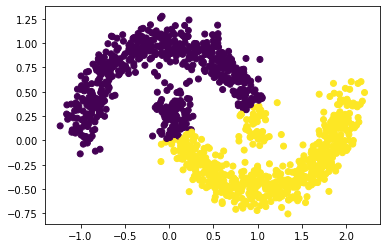

In [20]:
plot_algo(sgd)

Plotting momentum


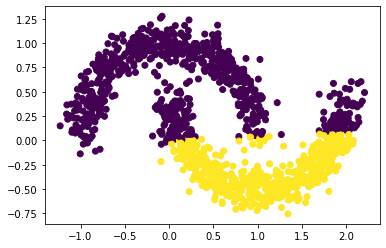

In [21]:
plot_algo(momentum)

Plotting nesterov


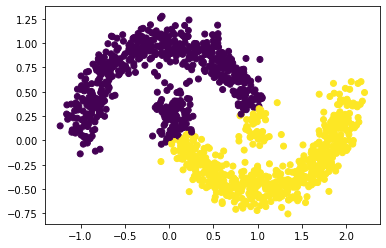

In [22]:
plot_algo(nesterov)

Plotting adagrad


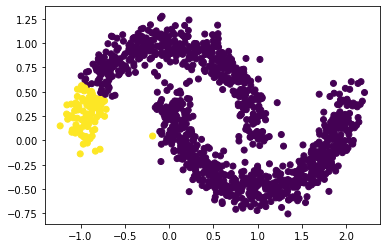

In [23]:
plot_algo(adagrad)

Plotting rmsprop


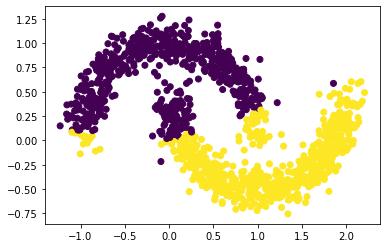

In [24]:
plot_algo(rmsprop)

Plotting adam


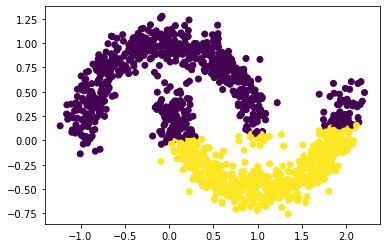

In [25]:
plot_algo(adam)